This notebook was originally written in Spanish. This English version was automatically generated using nbtranslate, so there may be some errors along the notebook. Sorry for the inconveniences.

# Introduction
In this document we are going to expand a series of queries using two models based on word embeddings: Word2Vec$^{[1]}$ and Glove$^{[2]}$. At the beginning, we will briefly explain how each of these models and their respective Python libraries work. Subsequently, a small comparison between both models will be made taking into account the P@k obtained in the consultations. Finally, a performance comparison of both models will also be made.

# Previous considerations
In this document we start with the collection of tweets already indexed in ElasticSearch. This step was done using the _index.py_ script, which is available in the _src_ folder of the delivery. The collection used is the default collection with tweets from February 4, 2008 in English.

# Setup
The first thing we are going to do is import the libraries that will be used throughout this work. As they are used, we will go on to detail the operation of the most important ones.

In [1]:
import string
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from adjustText import adjust_text
from elasticsearch import Elasticsearch, helpers
from elasticsearch_dsl import Search, Q
from gensim.models import word2vec
from glove import Glove
from glove import Corpus
from memory_profiler import memory_usage
from sklearn.decomposition import PCA
from stop_words import get_stop_words

%load_ext memory_profiler
%matplotlib inline

sys.path.append('../src/')

También iniciaremos la conexión con ElasticSearch. Además, indicamos el nombre de la colección dónde se realizarán las consultas.

We will also initiate the connection with ElasticSearch. In addition, we indicate the name of the collection where the queries will be made.

In [2]:
client = Elasticsearch()
index = '2008-feb-02-04-en'

# Description of the models
Before using each model we will briefly describe how they work. We will not go into detail in the internal workings of each one, but we will clarify what they do in broad strokes so that later when we train each model and see the results we can understand what happens' from behind'.<br> Both models produce as a result vectors that represent each word in the collection. In addition, these vectors also represent the relationships between several words, so by performing several operations between them we can obtain words related to the originals as a result.

## Word2Vec
Word2Vec uses a neural network to obtain word vectors from a series of documents. This model can use two different architectures to obtain the vectors:
- CBOW: In the case of CBOW (**C**ontinuous **b**ag **o**f **w**ords) , if we have the target word 'super', the input that will be used to train the neural network will be each of the words that surround the word 'super' in the document. The number of close words that are used to train the neural network is the 'context'. From this context, the weights of the hidden layer of the neural network are modified to obtain as a result a vector that represents the word 'super'. In other words, when training the model we try to maximize the probability that the word 'super' will be obtained given the context.
- Skip-gram: In this case, using the same example as for the CBOW model, the input to the neural network would be 'super', and the values ​​of the hidden layer would be modified to produce as a result each of the words that are find around 'super' (the context).

## Glove
According to Jeffrey Penington, creator of Glove, the model of Word2Vec is not at all optimal since it does not exploit to the maximum the statistics of each word$^{[3]}$.
In the case of GloVe (**Glo** bal **See** ctors for word representation), a co-occurrence matrix is ​​used that represents the statistics of each word to obtain the results . Each value $M_{ij}$ of this matrix represents how often the word i appears in the context of the word j. Once we have this matrix we can proceed to create the word vectors from it. To obtain these vectors we use a regression model quite sencillo$^{[4]}$, but in which we will not go into detail.

# Training the models
The first thing we need to do is train both models. To train them we will use the complete collection of tweets. Since we have a relatively large amount of documents (390000) and that is a good practice, we are going to create a class that will generate a list with the words of each tweet in the collection in a lazy way. In this way, we will not have to save all the tweets in the collection in a list in RAM memory.
The models receive an iterable as a parameter to be able to train them. All we have to do is implement the predefined python function \ _\_ iter \ _\_ inside our class so that the objects we create behave as an iterable one.

In addition, it is worth noting that before returning every word in the generator we made a small preprocessing to improve the performance of both Word2Vec and Glove. First, we will tokenize the tweet using the nltk library, which contains a module dedicated specifically to tokenize tweets. In addition, we will also eliminate the punctuation marks left by the tokenizer loose. In the event that the word is a link to an external page then we will not delete the punctuation symbols. Finally, we will eliminate the empty words of each tweet. The list of empty words was obtained using the external library _stop-words_ (to this list the word 'Re' was added to eliminate it from the retweets).

In [3]:
class SentencesGenerator:
    def __init__(self, client, index):
        self.s = Search(using=client, index=index).query(Q())
        self.stop_words = get_stop_words('english')
        self.stop_words.append('Re')
    
    def __iter__(self):
        # creamos una tabla de traducción que usaremos para eliminar los simbolos de puntuación.
        remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
        for tweet in self.s.scan():
            # tokenizamos el tweet
            words = nltk.tokenize.casual.casual_tokenize(tweet.text)
            
            # eliminamos los simbolos de puntuacion sobrantes
            words = [word.translate(remove_punctuation_map) for word in words
                     if not word.startswith('http')]
            
            # eliminamos palabras vacias
            words = [word for word in words if word != '' and word not in self.stop_words]
            yield words


sentences_generator = SentencesGenerator(client, index)

## Word2Vec training
The Word2Vec implementation of gensim$^{[6]}$ makes it very easy to train the model. The only thing that we will have to take into account are the parameters that we supply to the constructor. Below is a short description of each parameter used:
- The first parameter is the iterable mentioned above that is generated by each tweet with the separated words.
- Second, we want that the vectors generated by word2vec have a dimension equal to 100.
- In the third parameter we indicate that Word2Vec takes into account the 5 words next to the word given when training the model.
- The fourth parameter indicates that only words that appear at least 10 times in the collection are added to the vocabulary generated by word2vec. In this way we will eliminate many words with misspellings, links that are added to many tweets, or words that only make sense among small groups of people and therefore do not appear many times (for example, nicknames).
- Finally, we indicate that only one thread is used when training the model. This is because if we used more than 1 thread, small variations were observed in the vectors obtained each time the script was executed. With a thread we make sure to get deterministic results every time we train the model.

It should also be noted that the algorithm used is the CBOW (default algorithm).

In [4]:
w2v_model = word2vec.Word2Vec(sentences_generator, size=100, window=5, min_count=10, workers=1)

Now let's check that the model trained correctly by asking the words most similar to _football_:

In [5]:
w2v_model.wv.most_similar('football')

[('sports', 0.8340591192245483),
 ('rugby', 0.769142746925354),
 ('commercials', 0.7621728181838989),
 ('superbowl', 0.7548601627349854),
 ('game', 0.7532534599304199),
 ('soccer', 0.7483059167861938),
 ('halftime', 0.7467842102050781),
 ('SB', 0.7451385259628296),
 ('patriots', 0.7434816360473633),
 ('hype', 0.7361529469490051)]

As you can see, we get a list with 10 tuples that contain the words most similar to the given word. Each of these tuples stores the word and the level of similarity with the original word.

## Training the Glove model
In the case of Glove, the official implementation of the model is implemented in C. Therefore, taking into account the scope of this work, we will use a non-official implementation of the model written in python for convenience.<br> The way to train this model It is a bit different from the one used with Word2Vec. First we will use the class _Corpus_ to generate a co-occurrence matrix from an iterable number of sentences (the same iterable as for Word2Vec will be used). The parameter _window_ that is passed to the corpus has the same utility as in Word2Vec (number of nearby words that are taken into account). Once this is done, we will generate the word vectors from the co-occurrence matrix.

In [6]:
corpus = Corpus()
corpus.fit(sentences_generator, window=5)
glove_model = Glove(no_components=100, learning_rate=0.025)
glove_model.fit(corpus.matrix, epochs=20,
                no_threads=1, verbose=False)
glove_model.add_dictionary(corpus.dictionary)

Now we will check that the modeo was trained correctly, just like with Word2Vec:

In [7]:
glove_model.most_similar('football', number=10)

[('game', 0.94516615612233512),
 ('basketball', 0.93727661271892293),
 ('movies', 0.92516280325352163),
 ('tv', 0.91967929552238137),
 ('commercials', 0.91767825631607869),
 ('boring', 0.91659161375196796),
 ('superbowl', 0.90065063328450201),
 ('hockey', 0.89802726457058746),
 ('exciting', 0.88653115414210382)]

As we can see, once we have trained the models both are used almost identically.

# Drawing word vectors
Now that we have the models ready, we will draw a graph that will help us visualize how these models work. We will work with the Word2vec model, although these steps would be totally applicable to Glove as well. First let's check that each vector has 100 dimensions, as we indicated in the Word2Vec constructor:

In [8]:
len(w2v_model.wv['football'])

100

Words that usually appear in the same context will have similar vectors, while words that have nothing in common will tend to be far apart. In order to see this relationship we are going to reduce the dimensionality of some vectors to 2 dimensions using the PCA (Principal Component Analysis) technique:

In [9]:
words = ['American', 'Football', 'Conference', 'David', 'Tyree',
         'defensive', 'end', 'Eli', 'Manning', 'football',
         'Glendale', 'Laurence', 'Maroney', 'Miami', 'Dolphins',
         'Michael', 'Strahan', 'National', 'League', 'England',
         'Patriots', 'New', 'York', 'Giants', 'NFL', 'Plaxico',
         'Burress', 'quarterback', 'Randy', 'Moss', 'running',
         'back', 'Super', 'Bowl', 'Wide', 'receiver']

X_train = [w2v_model.wv[word] for word in w2v_model.wv.vocab]
X = [w2v_model.wv[word] for word in words]
pca = PCA(n_components=2)
pca.fit(X_train)
result = pca.transform(X)

Now that we have vectors in 2 dimensions, we can perform a scatter plot and draw each word in the plane:

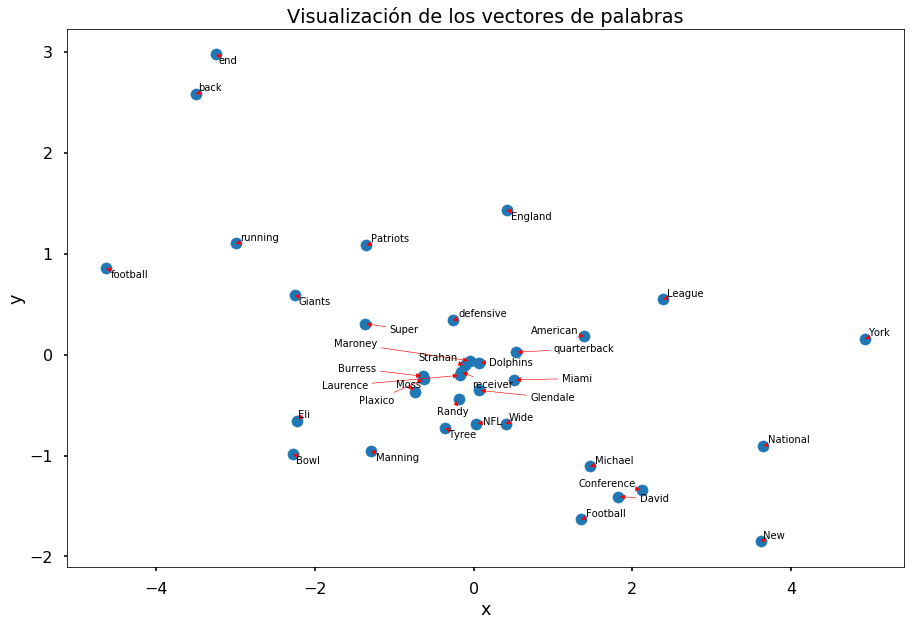

In [10]:
plt.style.use('seaborn-poster')

plt.title('Visualización de los vectores de palabras')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(result[:,0], result[:,1])

texts = []
for i, word in enumerate(words):
    texts.append(plt.text(result[i,0], result[i,1], word))

adjust_text(texts, force_text=0.55, arrowprops=dict(arrowstyle="-|>", color='r', lw=0.6))

plt.tight_layout()
plt.show()

# Query expansion

Now let's move on to expand a series of queries about the collection of tweets. The main idea will be to obtain a number k of similar terms for each term of the original query. For this we will start with a query q0: <br><br>
$$q_0 = t_1 + t_2 + t_3 + ... + t_n$$
<br>
Next we obtain the similar terms for each term of q0, and we perform an expanded query qe in this way: <br><br>
$$q_e = t_1 + sim(t1) + t_2 + sim(t_2)\ +\ ...\ +\ t_n + sim(t_n)$$
<br>
Once we have the expanded query for both the Word2Vec model and the Glove model, we will select the 10 results of the query with the highest score returned by ElasticSearch. Using our criteria, we will select which of these results seem relevant and which do not, and we will indicate if we obtain any benefit or not by comparing these results with the results of the original query. Finally, we will see that tweet went up and down more than the ranking when the expanded queries were made with respect to the original query.

To avoid that the size of the documentation is very large, we do not include the source code of the functions used in this section. This code, along with a brief description of each function, is available in the query_expansion.py file in the src folder.

In [11]:
from query_expansion import *

## Super Bowl
Let's start with the Super Bowl consultation. Since it is the first query that we expand, I will briefly explain the steps followed to obtain each result.

In [12]:
start_query = "Super Bowl"

### Original results
First we get the results without expanding the query (result_q0). In this variable we will save the first 1000 results returned by ElasticSearch, while in the following table we will show the first 10.

In [13]:
result_q0 = get_elasticsearch_result([['Super'], ['Bowl']], client, index)

| resultado | relevante | razón |
|:-----:|:----:|:---:|
|{{result_q0[0][0]}}   |Sí  |  |
|{{result_q0[1][0]}}   |Sí | |
|{{result_q0[2][0]}}   |Sí | |
|{{result_q0[3][0]}}   |No | |
|{{result_q0[4][0]}}   |No | Repetido |
|{{result_q0[5][0]}}   |No | Repetido |
|{{result_q0[6][0]}}   |No | Repetido |
|{{result_q0[7][0]}}   |No | Repetido |
|{{result_q0[8][0]}}   |No | Repetido |
|{{result_q0[9][0]}}   |No |  |

### Results Word2Vec
Now we will get the results of Word2Vec. First, we get the expanded query 'qe_w2v', and then we get the first 1000 tweets again (this time using the expanded query) and we show the top 10 in the table.

In [14]:
qe_w2v = get_expanded_query_w2v(w2v_model, start_query, k=3)
result_w2v = get_elasticsearch_result(qe_w2v, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_w2v[0][0]}}   |Sí  |  |
|{{result_w2v[1][0]}}   |Sí |  |
|{{result_w2v[2][0]}}   |No | Tweet sobre la puppy bowl |
|{{result_w2v[3][0]}}   |No | Tweet sobre la puppy bowl |
|{{result_w2v[4][0]}}   |No | Puppy bowl de nuevo |
|{{result_w2v[5][0]}}   |No | Stupor bowl|
|{{result_w2v[6][0]}}   |No |  |
|{{result_w2v[7][0]}}   |No | Stupor bowl |
|{{result_w2v[8][0]}}  |Sí |  |
|{{result_w2v[9][0]}}   |No | Stupor bowl |

### Glove Results
And finally with Glove, the procedure is exactly the same.

In [15]:
qe_glove = get_expanded_query_glove(glove_model, start_query, k=5)
result_glove = get_elasticsearch_result(qe_glove, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_glove[0][0]}}   |Sí  | Evaluación de los anuncios |
|{{result_glove[1][0]}}   |Sí | Anuncios de la Super Bowl |
|{{result_glove[2][0]}}   |No | Repetido |
|{{result_glove[3][0]}}   |Sí | Resultado de la Super Bowl|
|{{result_glove[4][0]}}   |Sí | Comienzo de la Super Bowl |
|{{result_glove[5][0]}}   |No | |
|{{result_glove[6][0]}}   |No | De nuevo anuncios |
|{{result_glove[7][0]}}   |No |  |
|{{result_glove[8][0]}}   |Sí | Anuncios primera parte |
|{{result_glove[9][0]}}   |Sí | Anuncios tercera parte |

### Changes of position of each tweet

In this section we will use the 1000 results previously saved from each query to see which tweets went up and down more than the original query.

#### Word2Vec

In [16]:
original_tweets = [pair[0] for pair in result_q0]
expanded_tweets = [pair[0] for pair in result_w2v]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'The Super Bowl is exciting, but the Puppy Bowl has puppies. http://tinyurl.com/2uhqez' subió 649 posiciones (desde la posicion 675 hasta la posicion 26)
El tweet '@pplwrd agreed, best super bowl ever!' descendió 518 posiciones (desde la posicion 364 hasta la posicion 882)


#### Glove

In [17]:
expanded_tweets = [pair[0] for pair in result_glove]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'looking forward to Super Bowl XLII. GO GIANTS!' subió 912 posiciones (desde la posicion 986 hasta la posicion 74)
El tweet '@pplwrd agreed, best super bowl ever!' descendió 565 posiciones (desde la posicion 364 hasta la posicion 929)


### Conclusion

In this case, as we can see, the results obtained with the original query do not provide much information in general and those of Word2Vec focus more on the Puppy Bowl than on the Super Bowl. However, with GloVe we get better results, focused mainly on the Super Bowl ads, and some comments on the beginning and the winner of it.

### Importance of the number of expanded terms
Before proceeding to the next query, we will observe what happens if we modify the number of terms that we expand for each original term in the case of Word2Vec:

In [18]:
qe_w2v = get_expanded_query_w2v(w2v_model, start_query, k=5)
result_w2v = get_elasticsearch_result(qe_w2v, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_w2v[0][0]}}   |No  | Super Mario Galaxy |
|{{result_w2v[1][0]}}   |No | Puppy Bowl |
|{{result_w2v[2][0]}}   |No | Super Mario Galaxy |
|{{result_w2v[3][0]}}   |No | Puppy Bowl |
|{{result_w2v[4][0]}}   |No | Puppy Bowl |
|{{result_w2v[5][0]}}   |No | Stupor Bowl|
|{{result_w2v[6][0]}}   |No | Puppy Bowl |
|{{result_w2v[7][0]}}   |No | Super Mario Galaxy |
|{{result_w2v[8][0]}}  |No | Super Mario Galaxy |
|{{result_w2v[9][0]}}   |No | Super Mario Galaxy |

After adding a couple of more terms we get some different results. Half of the results have to do with Super Mario Galaxy, which makes sense for Word2Vec, since the word 'Super' in addition to being related to 'Bowl' is also related to 'Mario' and 'Galaxy' in many others tweets However, if someone wants to see the tweets related to the Super Bowl and he finds tweets talking about Super Mario Galaxy, he probably will not enjoy it. Taking this into account, we can conclude that the selection of the number of terms to expand is a very critical process, in which a term more or less can drastically change the results.

## NFL

In [19]:
start_query = "NFL"

### Original results

In [20]:
result_q0 = get_elasticsearch_result([[start_query]], client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_q0[0][0]}}   |Sí | Relaciona NFL y Super Bowl |
|{{result_q0[1][0]}}   |No | Conversación |
|{{result_q0[2][0]}}   |No | Conversación |
|{{result_q0[3][0]}}   |No | Conversación |
|{{result_q0[4][0]}}   |No | Conversación |
|{{result_q0[5][0]}}   |Sí | Comentario Superbowl |
|{{result_q0[6][0]}}   |No | Conversación |
|{{result_q0[7][0]}}   |No | Conversación |
|{{result_q0[8][0]}}   |Sí | Enlace relacionado |
|{{result_q0[9][0]}}   |Sí | Comentario SuperBowl |

### Word2Vec results

In [21]:
qe_w2v = get_expanded_query_w2v(w2v_model, start_query, k=5)
result_w2v = get_elasticsearch_result(qe_w2v, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_w2v[0][0]}}   |Sí | Comentario sobre NFL |
|{{result_w2v[1][0]}}   |Sí | Noticia |
|{{result_w2v[2][0]}}   |Sí | Noticia |
|{{result_w2v[3][0]}}   |No | Repetido |
|{{result_w2v[4][0]}}   |No | Repetido |
|{{result_w2v[5][0]}}   |No | Repetido |
|{{result_w2v[6][0]}}   |No | Repetido |
|{{result_w2v[7][0]}}   |No | Repetido |
|{{result_w2v[8][0]}}   |No | Repetido |
|{{result_w2v[9][0]}}   |No | Repetido |

### GloVe results

In [22]:
qe_glove = get_expanded_query_glove(glove_model, start_query, k=2)
result_glove = get_elasticsearch_result(qe_glove, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_glove[0][0]}}   |Sí | Comentario del partido |
|{{result_glove[1][0]}}   |No | Comentario personal |
|{{result_glove[2][0]}}   |No | Comentario personal |
|{{result_glove[3][0]}}   |No |  |
|{{result_glove[4][0]}}   |Sí | Comentario del partido |
|{{result_glove[5][0]}}   |Sí | Comentario del partido |
|{{result_glove[6][0]}}   |Sí | Comentario del partido |
|{{result_glove[7][0]}}   |Sí | Noticia |
|{{result_glove[8][0]}}   |No | |
|{{result_glove[9][0]}}   |No | |

### Changes of positions of each tweet

#### Word2Vec

In [23]:
original_tweets = [pair[0] for pair in result_q0]
expanded_tweets = [pair[0] for pair in result_w2v]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'GLENDALE, Arizona (Reuters) - The New York Giants achieved one of the
biggest upsets in NFL history with a 17-14 victory over the previo ...' subió 685 posiciones (desde la posicion 686 hasta la posicion 1)
El tweet 'Xbox Live: allcoldinside is currently Away. Last seen 5 hours ago playing Madden NFL 06. Franchise: Pre-Season. (Title: Madden NFL 06)' descendió 547 posiciones (desde la posicion 146 hasta la posicion 693)


#### Glove

In [24]:
expanded_tweets = [pair[0] for pair in result_glove]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'GLENDALE, Arizona (Reuters) - The New York Giants achieved one of the
biggest upsets in NFL history with a 17-14 victory over the previo ...' subió 645 posiciones (desde la posicion 686 hasta la posicion 41)
El tweet 'Voice of America

NFL Commissioner Addresses Super Bowl Media
Voice of America - 2 hours ago
By Parke Brewer Less than a week after Pres ...' descendió 543 posiciones (desde la posicion 445 hasta la posicion 988)


### Conclusion

In this case, for the "NFL" query, we would choose to use Glove, since it extracts better results in the query expansion than Word2Vec, which in this case takes many repeated tweets, and without expanding the queries, since it shows results without relevance. Instead, using Glove, we get a variety of relevant results about the NFL and the Super Bowl.

## Eli Manning

In [25]:
start_query = "Eli Manning"

### Original results

In [26]:
result_q0 = get_elasticsearch_result([['Eli'], ['Manning']], client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_q0[0][0]}}   |Sí | Comentario del partido |
|{{result_q0[1][0]}}   |No |  |
|{{result_q0[2][0]}}   |Sí |  |
|{{result_q0[3][0]}}   |No |  |
|{{result_q0[4][0]}}   |No |  |
|{{result_q0[5][0]}}   |No |  |
|{{result_q0[6][0]}}   |No | Repetido |
|{{result_q0[7][0]}}   |No |  |
|{{result_q0[8][0]}}   |No |  |
|{{result_q0[9][0]}}   |No | Conversación |

### Word2Vec results

In [27]:
qe_w2v = get_expanded_query_w2v(w2v_model, start_query, k=4)
result_w2v = get_elasticsearch_result(qe_w2v, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_w2v[0][0]}}   |No |  |
|{{result_w2v[1][0]}}   |Sí | Comentario partido |
|{{result_w2v[2][0]}}   |No | Repetido |
|{{result_w2v[3][0]}}   |No | Repetido |
|{{result_w2v[4][0]}}   |Sí |  |
|{{result_w2v[5][0]}}   |No | Repetido |
|{{result_w2v[6][0]}}   |No | Repetido |
|{{result_w2v[7][0]}}   |No | Repetido |
|{{result_w2v[8][0]}}   |No | Repetido |
|{{result_w2v[9][0]}}   |No | Repetido |

### Glove results

In [28]:
qe_glove = get_expanded_query_glove(glove_model, start_query, k=5)
result_glove = get_elasticsearch_result(qe_glove, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_glove[0][0]}}   |Sí | Comentario del partido |
|{{result_glove[1][0]}}   |No | Repetido |
|{{result_glove[2][0]}}   |No | Repetido |
|{{result_glove[3][0]}}   |No | Repetido |
|{{result_glove[4][0]}}   |No | Repetido |
|{{result_glove[5][0]}}   |No | Repetido |
|{{result_glove[6][0]}}   |Sí | Comentario del partido |
|{{result_glove[7][0]}}   |No | Repetido |
|{{result_glove[8][0]}}   |No | Repetido |
|{{result_glove[9][0]}}   |No | Repetido |

### Changes of positions of each tweet

#### Word2Vec

In [29]:
original_tweets = [pair[0] for pair in result_q0]
expanded_tweets = [pair[0] for pair in result_w2v]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'I said Eli would win the MVP just like his brother Peyton did last year!
Sorry Pats...you're just not THAT perfect!' subió 841 posiciones (desde la posicion 925 hasta la posicion 84)
El tweet 'Manning Keeps Cool, and Keeps a Drive Alive http://tinyurl.com/36oap7' descendió 190 posiciones (desde la posicion 625 hasta la posicion 815)


#### Glove

In [30]:
expanded_tweets = [pair[0] for pair in result_glove]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'Best super bowl game I've seen to this day. Well played on both sides and Eli definitely deserved that MVP.' subió 670 posiciones (desde la posicion 868 hasta la posicion 198)
El tweet 'Manning Keeps Cool, and Keeps a Drive Alive http://tinyurl.com/36oap7' descendió 296 posiciones (desde la posicion 625 hasta la posicion 921)


### Conclusion

In the case of the query "Eli Manning", we can see that either using Word2Vec query expansion, or Glove without expanding, we get very similar results on the performance in the game Superbowl Eli Manning. However, when observing the changes of position of the tweets in each model, we can see that using Glove, the tweet that increased positions was one not related to the MVP Eli Manning, while with Word2Vec was one talking about this same topic. Therefore, if we had to choose a model, we would use Glove since it is more exhaustive in its results than Word2Vec in this case.

## New York Giants

In [31]:
start_query = "New York Giants"

### Original results

In [32]:
result_q0 = get_elasticsearch_result([['New'], ['York'], ['Giants']], client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_q0[0][0]}}   |No |  |
|{{result_q0[1][0]}}   |Sí | Comentario del partido |
|{{result_q0[2][0]}}   |No |  |
|{{result_q0[3][0]}}   |No | Repetido |
|{{result_q0[4][0]}}   |No | Repetido |
|{{result_q0[5][0]}}   |No | Repetido |
|{{result_q0[6][0]}}   |No |  |
|{{result_q0[7][0]}}   |No |  |
|{{result_q0[8][0]}}   |No | Repetido |
|{{result_q0[9][0]}}   |No | Repetido |

### Word2Vec results

In [33]:
qe_w2v = get_expanded_query_w2v(w2v_model, start_query, k=3)
result_w2v = get_elasticsearch_result(qe_w2v, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_w2v[0][0]}}   |No | Conversación |
|{{result_w2v[1][0]}}   |No | Conversación |
|{{result_w2v[2][0]}}   |Sí | Comentario del partido |
|{{result_w2v[3][0]}}   |Sí | Comentario post-partido |
|{{result_w2v[4][0]}}   |Sí | Noticia post-partido |
|{{result_w2v[5][0]}}   |No |  |
|{{result_w2v[6][0]}}   |No |  |
|{{result_w2v[7][0]}}   |Sí | Comentario pre-partido |
|{{result_w2v[8][0]}}   |No |  |
|{{result_w2v[9][0]}}   |No |  |

### Glove results

In [34]:
qe_glove = get_expanded_query_glove(glove_model, start_query, k=4)
result_glove = get_elasticsearch_result(qe_glove, client, index)

| resultado | relevante | razón |
| :-----: |:----:|:---:|
|{{result_glove[0][0]}}   |Sí | Comentario del partido |
|{{result_glove[1][0]}}   |No | Repetido |
|{{result_glove[2][0]}}   |Sí | Comentario del partido |
|{{result_glove[3][0]}}   |No | Repetido |
|{{result_glove[4][0]}}   |No | Repetido |
|{{result_glove[5][0]}}   |No | Repetido |
|{{result_glove[6][0]}}   |No | Repetido |
|{{result_glove[7][0]}}   |No | Repetido |
|{{result_glove[8][0]}}   |No | Conversación |
|{{result_glove[9][0]}}   |No | Conversación |

### Changes of positions of each tweet

#### Word2Vec

In [35]:
original_tweets = [pair[0] for pair in result_q0]
expanded_tweets = [pair[0] for pair in result_w2v]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'giants or pats giants or pats' subió 932 posiciones (desde la posicion 938 hasta la posicion 6)
El tweet 'NEW YORK (Reuters) - A record number of Americans watched Sunday's Super
Bowl on Fox between the New York Giants and New England Patriot ...' descendió 535 posiciones (desde la posicion 84 hasta la posicion 619)


#### Glove

In [36]:
expanded_tweets = [pair[0] for pair in result_glove]
show_most_improved_tweet(original_tweets, expanded_tweets)
show_most_devaluated_tweet(original_tweets, expanded_tweets)

El tweet 'giants or pats giants or pats' subió 834 posiciones (desde la posicion 938 hasta la posicion 104)
El tweet 'TheOnlinewire

Giants stand between Patriots and the history books
Washington Post - 5 hours ago
PHOENIX (Reuters) - The New York Giants ...' descendió 883 posiciones (desde la posicion 78 hasta la posicion 961)


### Conclusion

When consulting the "New York Giants", winning team of the Super Bowl 2008, we obtain quite different results depending on the model we use. If we use the original results, without expanding the query, we get "empty" results, since in those tweets we only find exclamations and the name of the winning team. If we use Glove, we also get very similar results from each other, congratulating the winning team. On the other hand, if we use Word2Vec, we obtain mixed results on the pre and post game, and on the game itself, obviously. Unlike in the previous cases, the tweets that increased the number of posts in Word2Vec and Glove are the same in both models, so using the information obtained in the query expansion, in this case we would use Word2Vec.

## Precisions obtained with each model

With all the data previously collected, we can show in a table the precisions obtained for the 5 and 10 first results of each query. The results obtained are the following:

In [37]:
d = {'Sin expandir consulta': ['{}%'.format(7/20 * 100),
                               '{}%'.format(10/40* 100)], 
     'Expansión usando Word2vec': ['{}%'.format(10/20 * 100),
                                   '{}%'.format(12/40* 100)], 
     'Expansión usando GloVe': ['{}%'.format(9/20 * 100),
                                '{}%'.format(15/40* 100)]
    }
df = pd.DataFrame(data=d, index=['P@5', 'P@10']) 
df

,Expansión usando GloVe,Expansión usando Word2vec,Sin expandir consulta
P@5,45.0%,50.0%,35.0%
P@10,37.5%,30.0%,25.0%


As we can see, for our test queries both models get more relevant results than if we did not expand the queries. We can also see that Word2Vec gives slightly better results for the first 5 tweets, while GloVe obtains better results if we consider the first 10 tweets. In all cases the accuracy drops considerably when taking into account the first 10 tweets, although this is largely due to the fact that many of the last 5 tweets usually contain the same information as the first 5, so we do not consider them relevant.

# Performance of the models
Before finishing, we will make some measurements on both models to see how long it takes to train on the collection of tweets and the memory used by each one.

In [38]:
import profiler

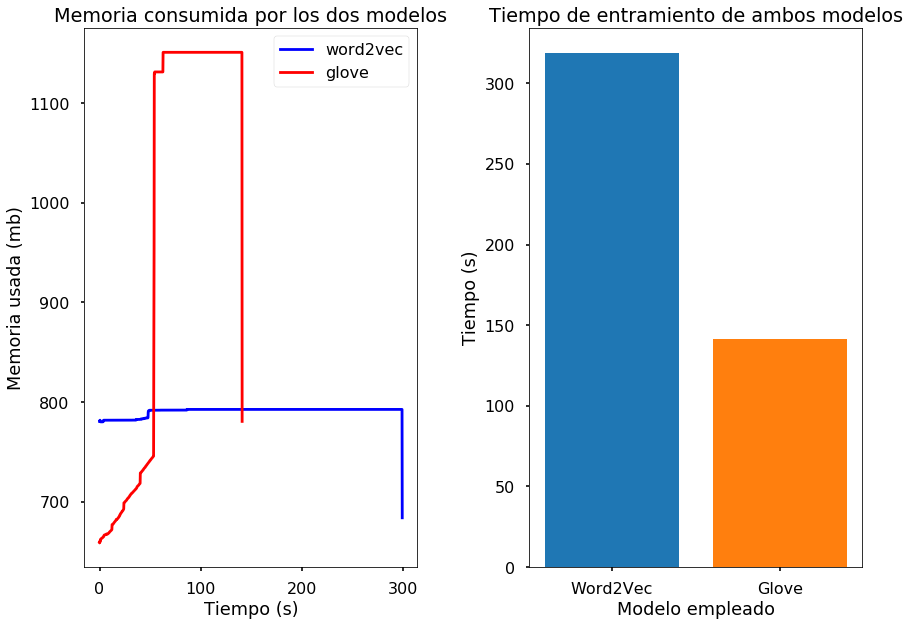

In [39]:
mem_usage_glove = memory_usage((profiler.glove_benchmark, (sentences_generator,), {}))
mem_usage_w2v = memory_usage((profiler.word2vec_benchmark, (sentences_generator,), {}))
time_glove = %timeit -n1 -r1 -o -q profiler.glove_benchmark(sentences_generator)
time_w2v = %timeit -n1 -r1 -o -q profiler.word2vec_benchmark(sentences_generator)
profiler.plot_results(mem_usage_glove, mem_usage_w2v, time_glove, time_w2v)

As we can see, the GloVe model uses much more memory than Word2Vec. This is totally logical since you have to build the co-occurrence matrix already described above. However, the execution time of Glove is quite inferior to that of Word2Vec, reaching to take almost half. For a relatively small collection like ours, the difference is not much appreciated, but if much larger collections are used, this can be an interesting factor to take into account when deciding on one model or another.

# References

[1] Explanation of the operation of Google's Word2Vec model. https://code.google.com/archive/p/word2vec/

[2] Explanation of the operation of the Stanford Glove model. https://nlp.stanford.edu/projects/glove/

[3] GloVe: Global Vectors for word representation. https://www.aclweb.org/anthology/D14-1162

[4] Explanation of how GloVe works and how to implement the model in Python. http://www.foldl.me/2014/glove-python/

[5] NLTK tweets source code. http://www.nltk.org/_modules/nltk/tokenize/casual.html

[6] Documentation of the gensim word2vec module used. https://radimrehurek.com/gensim/models/word2vec.html

[7] Repository in github of the Glove implementation used. https://github.com/maciejkula/glove-python